In [1]:

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

vocabulary = ["banana", "chocolate"]

# Dirichlet priors for two text types
theta_1 = np.random.dirichlet([1, 3])
theta_2 = np.random.dirichlet([3, 1])


In [2]:
theta_1

array([0.46091352, 0.53908648])

In [3]:
theta_2

array([0.74711608, 0.25288392])

In [4]:

def generate_text(theta, base_length=150, length_jitter=30):
    """
    text generator using multinomial sampling.
    
    theta: word probability vector
    base_length: mean doc length
    length_jitter: Poisson noise for variation
    """
    # Draw random doc length
    w = np.random.poisson(base_length) + length_jitter

    # Sample word counts
    counts = np.random.multinomial(w, theta)

    # Build shuffled text
    words = []
    for word, count in zip(vocabulary, counts):
        words.extend([word] * count)
    np.random.shuffle(words)
    
    return " ".join(words)

# Generate documents
n = 100
texts_1 = [generate_text(theta_1) for _ in range(n)]
texts_2 = [generate_text(theta_2) for _ in range(n)]

all_texts = texts_1 + texts_2
labels = [1]*n + [2]*n

# Build DTM
vectorizer = CountVectorizer(vocabulary=vocabulary)
dtm = vectorizer.fit_transform(all_texts).toarray()

dtm_df = pd.DataFrame(dtm, columns=vocabulary)
dtm_df["class"] = labels

dtm_df.head()


banana  chocolate  class
0      81         98      1
1      84         94      1
2      87         84      1
3      96        111      1
4     102         96      1

In [5]:

X = dtm_df[["banana", "chocolate"]].values

X

array([[ 81,  98],
       [ 84,  94],
       [ 87,  84],
       [ 96, 111],
       [102,  96],
       [ 72,  95],
       [ 90,  94],
       [ 93,  90],
       [ 82,  93],
       [ 78,  85],
       [ 82,  88],
       [ 83,  99],
       [ 81, 112],
       [ 75,  86],
       [ 89,  94],
       [ 81,  97],
       [ 89,  97],
       [ 84, 105],
       [ 81, 100],
       [ 86, 102],
       [ 83, 104],
       [ 85, 101],
       [ 79, 105],
       [ 81,  97],
       [ 83,  95],
       [ 77,  84],
       [102,  85],
       [ 88,  95],
       [ 90, 107],
       [ 79,  86],
       [ 72,  93],
       [ 83, 101],
       [ 91, 101],
       [ 67,  80],
       [ 87,  98],
       [ 98,  90],
       [ 79, 104],
       [ 63, 107],
       [ 80, 109],
       [ 86,  94],
       [ 79,  98],
       [ 85,  94],
       [ 70,  94],
       [ 84,  90],
       [ 78,  92],
       [ 70, 101],
       [ 74, 116],
       [ 83, 100],
       [ 68,  88],
       [ 78,  94],
       [ 87,  96],
       [ 83,  96],
       [ 83,

In [6]:


def manual_kmeans(X, k=2, max_iter=10, random_state=42):
    """
    Args:
        X (array): Data matrix (n_samples × n_features)
        k (int): number of clusters
        max_iter (int): maximum K-Means iterations
        random_state (int)

    Returns:
        centroid_history (list of arrays): centroids at each iteration
        label_history (list of arrays): cluster assignments per iteration
        final_labels (list): final class assignment
    """

    np.random.seed(random_state)
    n_samples = X.shape[0]

    # Initialization
    initial_idx = np.random.choice(n_samples, k, replace=False)
    centroids = X[initial_idx]

    centroid_history = [centroids.copy()]
    label_history = []

    # Iteration
    for _ in range(max_iter):

        # Assign each point to closest centroid
        distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
        labels_iter = np.argmin(distances, axis=1)
        label_history.append(labels_iter.copy())

        # Update centroids
        new_centroids = np.array([
            X[labels_iter == j].mean(axis=0)
            for j in range(k)
        ])

        centroid_history.append(new_centroids.copy())

        # Stop if converged
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return centroid_history, label_history, labels_iter


In [7]:
centroid_history, label_history, final_labels = manual_kmeans(
    X,
    k=2,
    max_iter=10,
    random_state=666
)

In [8]:
len(label_history), len(centroid_history), len(final_labels)

(2, 3, 200)

In [9]:
centroid_history

[array([[ 98,  90],
        [134,  43]]),
 array([[ 82.53,  97.16],
        [134.95,  46.25]]),
 array([[ 82.53,  97.16],
        [134.95,  46.25]])]

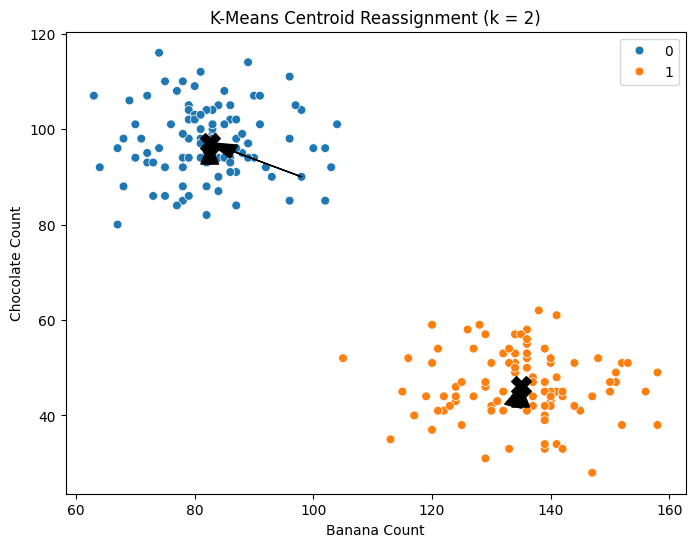

In [10]:
plt.figure(figsize=(8, 6))

# Determine dynamic k from final centroid shape
k_dynamic = centroid_history[-1].shape[0]

# Plot final clusters
sns.scatterplot(
    x=X[:, 0], 
    y=X[:, 1], 
    hue=final_labels, 
    palette="tab10",
    s=40
)

# Plot centroid movement arrows
for i in range(1, len(centroid_history)):
    old = centroid_history[i - 1]
    new = centroid_history[i]

    for c in range(k_dynamic):
        plt.arrow(
            old[c, 0], old[c, 1],
            new[c, 0] - old[c, 0],
            new[c, 1] - old[c, 1],
            color="black",
            head_width=3,
            length_includes_head=True
        )

# Plot final centroids
for c in range(k_dynamic):
    plt.scatter(
        centroid_history[-1][c, 0],
        centroid_history[-1][c, 1],
        s=200,
        c="black",
        marker="X"
    )

plt.title(f"K-Means Centroid Reassignment (k = {k_dynamic})")
plt.xlabel("Banana Count")
plt.ylabel("Chocolate Count")
plt.show()

In [11]:
%matplotlib inline
from matplotlib import rc
rc('animation', html='jshtml')

In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

def update(frame):
    ax.clear()

    labels = label_history[frame]
    centroids = centroid_history[frame]

    # extract the number of clusters from centroids shape
    k_dynamic = centroids.shape[0]

    ax.scatter(
        X[:, 0],
        X[:, 1],
        c=labels,
        cmap="tab10",   # tab10 supports up to 10 clusters
        s=40
    )

    ax.scatter(
        centroids[:, 0],
        centroids[:, 1],
        s=200,
        c="black",
        marker="X"
    )

    # Draw arrows 
    if frame > 0:
        old = centroid_history[frame - 1]
        new = centroid_history[frame]

        for c in range(k_dynamic):
            ax.arrow(
                old[c, 0], old[c, 1],
                new[c, 0] - old[c, 0],
                new[c, 1] - old[c, 1],
                color="black",
                head_width=3,
                length_includes_head=True
            )

    # Axes formatting
    ax.set_xlim(X[:, 0].min() - 10, X[:, 0].max() + 10)
    ax.set_ylim(X[:, 1].min() - 10, X[:, 1].max() + 10)
    ax.set_xlabel("Banana Count")
    ax.set_ylabel("Chocolate Count")
    ax.set_title(f"K-Means Iteration {frame} (k = {k_dynamic})")

ani = FuncAnimation(
    fig,
    update,
    frames=len(label_history),
    interval=1200,
    repeat=False
)

ani


In [13]:
# Add more text data

n = 100
vocabulary = ["banana", "chocolate"]

# Cluster 1: Dirichlet([1,2]), average length ~150
text_type_1 = [
    generate_text(
        theta=np.random.dirichlet([1, 2]),
        base_length=150,
        length_jitter=30
    )
    for _ in range(n)
]

# Cluster 2: Dirichlet([2,1]), average length ~150
text_type_2 = [
    generate_text(
        theta=np.random.dirichlet([2, 1]),
        base_length=150,
        length_jitter=30
    )
    for _ in range(n)
]

# Cluster 3: Dirichlet([50,50]), longer docs (~250 words)
text_type_3 = [
    generate_text(
        theta=np.random.dirichlet([50, 50]),
        base_length=250,
        length_jitter=40
    )
    for _ in range(500)
]

# Combine
all_texts = text_type_1 + text_type_2 + text_type_3
labels = [1]*n + [2]*n + [3]*500


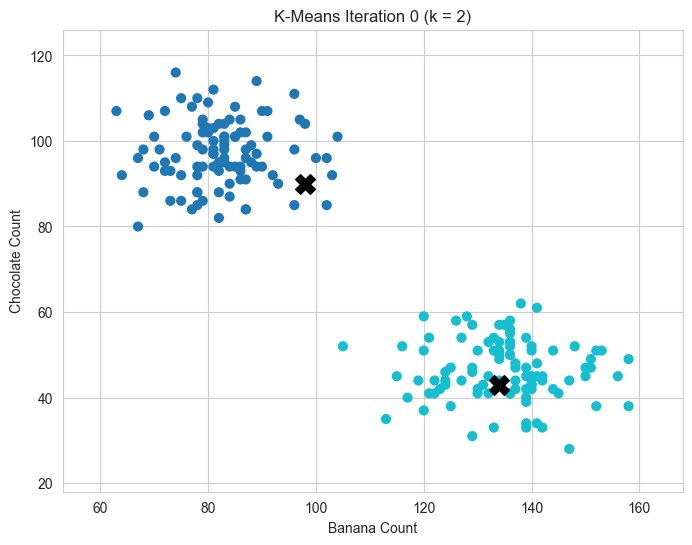

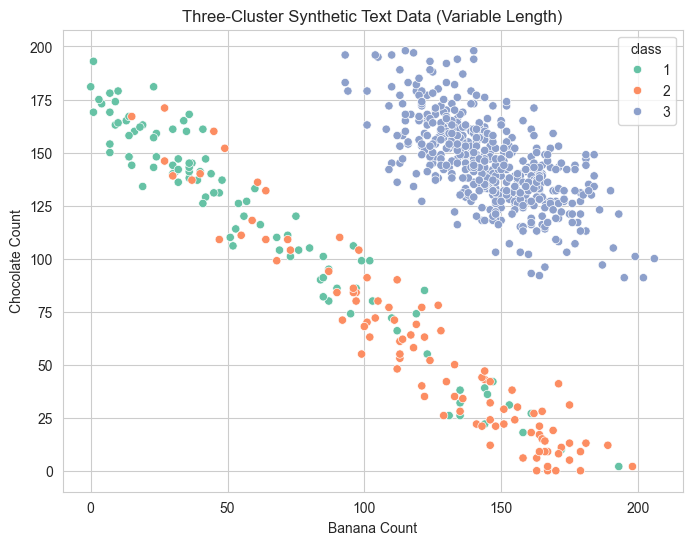

In [14]:
dtm = vectorizer.fit_transform(all_texts).toarray()
dtm_df = pd.DataFrame(dtm, columns=vocabulary)
dtm_df["class"] = labels

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=dtm_df,
    x="banana", y="chocolate",
    hue="class", palette="Set2", legend="full"
)
plt.title("Three-Cluster Synthetic Text Data (Variable Length)")
plt.xlabel("Banana Count")
plt.ylabel("Chocolate Count")
plt.show()


In [15]:
X = dtm_df[["banana", "chocolate"]].values
k = 3
max_iter = 10


centroid_history, label_history, final_labels = manual_kmeans(
    X,
    k=k,
    max_iter=10,
    random_state=666
)


In [16]:
ani = FuncAnimation(
    fig,
    update,
    frames=len(label_history),
    interval=1200,
    repeat=False
)

ani

/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklea

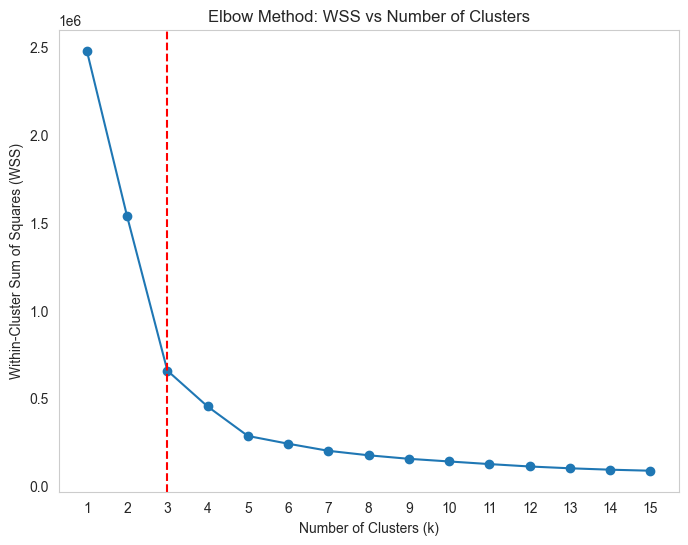

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def compute_wss(data, max_k=15):
    """
    Compute Within-Cluster Sum of Squares (WSS) for KMeans with k = 1..max_k.
    """
    wss = []
    for k in range(1, max_k + 1):
        model = KMeans(n_clusters=k, n_init=10, random_state=123)
        model.fit(data)
        wss.append(model.inertia_)   # WSS
    return wss

# Compute WSS
max_k = 15
wss_values = compute_wss(dtm, max_k)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k + 1), wss_values, marker='o')
plt.title("Elbow Method: WSS vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.axvline(3, color='red', linestyle='--', label='True k = 3')
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.xticks(range(1, max_k + 1))
plt.grid()
plt.show()


# Topic Modeling

## Better in r

In [18]:
!pip install gensim


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [19]:
import spacy

nlp = spacy.load("en_core_web_md", disable=["ner", "parser"])

In [20]:
raw_text = "Hello, my name is Peter, I love APPLES!!!!!!!"



In [22]:
parsed_text = nlp(raw_text)

In [24]:
for token in parsed_text:
    print(token)

Hello
,
my
name
is
Peter
,
I
love
APPLES
!
!
!
!
!
!
!


In [26]:
for token in parsed_text:
    print(token.lemma_)

hello
,
my
name
be
Peter
,
I
love
APPLES
!
!
!
!
!
!
!


In [27]:
for token in parsed_text:
    print(token.is_stop)

False
False
True
True
True
False
False
True
False
False
False
False
False
False
False
False
False


In [28]:

def spacy_preprocess(text):
    """
    - tokenize
    - lowercase
    - remove stopwords
    - remove punctuation
    - lemmatize
    """
    doc = nlp(text)
    tokens = [
        tok.lemma_.lower()
        for tok in doc
        if tok.is_alpha
        and not tok.is_stop
    ]
    return tokens

In [29]:
# Load the text data
sotu = pd.read_csv('sotu.csv')
# Inspect the data
print(sotu.head())


print(sotu['text'][0])

sotu = sotu[sotu['year'] >= 1901].reset_index(drop=True)

   X          president  year years_active        party sotu_type  \
0  1  George Washington  1790    1789-1793  Nonpartisan    speech   
1  2  George Washington  1790    1789-1793  Nonpartisan    speech   
2  3  George Washington  1791    1789-1793  Nonpartisan    speech   
3  4  George Washington  1792    1789-1793  Nonpartisan    speech   
4  5  George Washington  1793    1793-1797  Nonpartisan    speech   

                                                text  
0  Fellow-Citizens of the Senate and House of Rep...  
1  \n\n Fellow-Citizens of the Senate and House o...  
2  \n\n Fellow-Citizens of the Senate and House o...  
3  Fellow-Citizens of the Senate and House of Rep...  
4  \n\n Fellow-Citizens of the Senate and House o...  
Fellow-Citizens of the Senate and House of Representatives: 

I embrace with great satisfaction the opportunity which now presents itself of congratulating you on the present favorable prospects of our public affairs. The recent accession of the important

In [30]:
processed_docs = [spacy_preprocess(doc) for doc in sotu['text']]

In [32]:
processed_docs[1]

['senate',
 'house',
 'representatives',
 'continue',
 'period',
 'unbounded',
 'prosperity',
 'prosperity',
 'creature',
 'law',
 'undoubtedly',
 'law',
 'work',
 'instrumental',
 'create',
 'condition',
 'possible',
 'unwise',
 'legislation',
 'easy',
 'destroy',
 'undoubtedly',
 'period',
 'depression',
 'wave',
 'recede',
 'tide',
 'advance',
 'nation',
 'seat',
 'continent',
 'flank',
 'great',
 'ocean',
 'compose',
 'man',
 'descendant',
 'pioneer',
 'sense',
 'pioneer',
 'man',
 'winnow',
 'nation',
 'old',
 'world',
 'energy',
 'boldness',
 'love',
 'adventure',
 'find',
 'eager',
 'heart',
 'nation',
 'place',
 'surely',
 'wrest',
 'success',
 'fortune',
 'people',
 'play',
 'large',
 'world',
 'bent',
 'make',
 'future',
 'large',
 'past',
 'particular',
 'event',
 'year',
 'definitely',
 'decide',
 'woe',
 'weal',
 'place',
 'great',
 'nation',
 'fall',
 'greatly',
 'succeed',
 'greatly',
 'avoid',
 'endeavor',
 'great',
 'failure',
 'great',
 'success',
 'come',
 'play',
 '

In [33]:
from gensim.corpora import Dictionary

# Create dictionary (word → id mapping)
dictionary = Dictionary(processed_docs)

dictionary.filter_extremes(
    no_below=5,      # remove words that appear in <= 5 docs
    no_above=0.95     # remove words that appear in >= 95% of the docs
)

# Bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [34]:
dictionary

In [35]:
corpus

[[(0, 2),
  (1, 4),
  (2, 6),
  (3, 12),
  (4, 2),
  (5, 1),
  (6, 7),
  (7, 4),
  (8, 1),
  (9, 1),
  (10, 3),
  (11, 2),
  (12, 1),
  (13, 7),
  (14, 2),
  (15, 1),
  (16, 9),
  (17, 1),
  (18, 5),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 2),
  (24, 1),
  (25, 2),
  (26, 2),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 2),
  (32, 1),
  (33, 12),
  (34, 3),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 2),
  (39, 7),
  (40, 7),
  (41, 1),
  (42, 6),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 12),
  (47, 1),
  (48, 1),
  (49, 4),
  (50, 8),
  (51, 5),
  (52, 8),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 3),
  (57, 3),
  (58, 4),
  (59, 1),
  (60, 1),
  (61, 6),
  (62, 1),
  (63, 2),
  (64, 1),
  (65, 3),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 4),
  (72, 2),
  (73, 1),
  (74, 7),
  (75, 1),
  (76, 10),
  (77, 10),
  (78, 1),
  (79, 1),
  (80, 8),
  (81, 1),
  (82, 1),
  (83, 3),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 2),
  (89, 1),
  (90, 3),
  (9

In [43]:
from gensim.models.ldamodel import LdaModel

num_topics = 15

lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=10,
    random_state=42
)

In [44]:
for i, topic in lda.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print(f"Topic {i}: {[word for word, _ in topic]}")

Topic 0: ['law', 'business', 'america', 'federal', 'interest', 'service', 'present', 'program', 'help', 'propose']
Topic 1: ['federal', 'program', 'law', 'public', 'department', 'free', 'business', 'help', 'legislation', 'present']
Topic 2: ['america', 'job', 'americans', 'help', 'tonight', 'child', 'family', 'let', 'want', 'business']
Topic 3: ['federal', 'bank', 'credit', 'depression', 'large', 'recovery', 'public', 'construction', 'emergency', 'financial']
Topic 4: ['law', 'program', 'federal', 'legislation', 'service', 'public', 'america', 'business', 'force', 'effort']
Topic 5: ['program', 'federal', 'administration', 'energy', 'effort', 'legislation', 'development', 'million', 'health', 'propose']
Topic 6: ['flood', 'agriculture', 'farmer', 'profitable', 'federal', 'public', 'property', 'finance', 'education', 'law']
Topic 7: ['law', 'department', 'public', 'present', 'service', 'foreign', 'court', 'interest', 'general', 'purpose']
Topic 8: ['free', 'soviet', 'defense', 'communis

In [45]:
lda.print_topics(num_topics=5, num_words=5)

[(np.int64(6),
  '0.007*"flood" + 0.005*"agriculture" + 0.004*"farmer" + 0.004*"profitable" + 0.004*"federal"'),
 (np.int64(13),
  '0.012*"america" + 0.008*"help" + 0.007*"program" + 0.006*"child" + 0.006*"americans"'),
 (np.int64(3),
  '0.013*"federal" + 0.013*"bank" + 0.009*"credit" + 0.008*"depression" + 0.007*"large"'),
 (np.int64(2),
  '0.014*"america" + 0.009*"job" + 0.008*"americans" + 0.007*"help" + 0.006*"tonight"'),
 (np.int64(1),
  '0.002*"federal" + 0.002*"program" + 0.002*"law" + 0.002*"public" + 0.002*"department"')]

In [46]:
doc_topics = [lda.get_document_topics(bow) for bow in corpus]

doc_topics

[[(9, np.float32(0.9924848))],
 [(7, np.float32(0.071802065)),
  (9, np.float32(0.6654566)),
  (11, np.float32(0.26250178))],
 [(7, np.float32(0.51278526)),
  (9, np.float32(0.06673494)),
  (11, np.float32(0.2455797)),
  (14, np.float32(0.17476274))],
 [(7, np.float32(0.010313653)),
  (9, np.float32(0.219537)),
  (11, np.float32(0.7693141))],
 [(11, np.float32(0.99538296))],
 [(9, np.float32(0.7735794)), (11, np.float32(0.22191261))],
 [(7, np.float32(0.026858235)), (11, np.float32(0.9720587))],
 [(7, np.float32(0.051541507)),
  (9, np.float32(0.69520533)),
  (11, np.float32(0.25313583))],
 [(7, np.float32(0.99814147))],
 [(7, np.float32(0.99404216))],
 [(7, np.float32(0.995594))],
 [(7, np.float32(0.99110085))],
 [(7, np.float32(0.024958748)), (14, np.float32(0.97427934))],
 [(14, np.float32(0.9993006))],
 [(14, np.float32(0.997417))],
 [(7, np.float32(0.20274544)),
  (11, np.float32(0.08479289)),
  (14, np.float32(0.71140444))],
 [(14, np.float32(0.99919575))],
 [(14, np.float32(0.99

In [47]:
!pip install pyLDAvis


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [48]:

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


In [49]:
# Prepare the visualization
vis = gensimvis.prepare(lda, corpus, dictionary)

pyLDAvis.enable_notebook()

vis
# Save the visualization to an HTML file
# pyLDAvis.save_html(vis, 'lda_visualization.html')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.050847 -0.084153       1        1  17.644719
7     -0.115311  0.011638       2        1  16.545635
13     0.114481 -0.010206       3        1  16.077359
10     0.027320 -0.037706       4        1  14.391341
2      0.163120  0.037576       5        1  13.231835
11    -0.096054  0.069225       6        1   7.970698
9     -0.065819  0.068680       7        1   7.010310
14    -0.040985  0.057717       8        1   4.390236
8      0.088597  0.011089       9        1   1.721887
3     -0.088880 -0.166059      10        1   0.950876
6     -0.030713  0.003112      11        1   0.055923
4     -0.009659  0.012447      12        1   0.002295
12     0.017983 -0.002071      13        1   0.002295
1     -0.003351  0.008396      14        1   0.002295
0     -0.011574  0.020314      15        1   0.002295, topic_info=                Term         Freq        Total Category  logprob  loglift
3712         program  1945.000000  1945.000000  Default  30.0000  30.0000
743          federal  1641.000000  1641.000000  Default  29.0000  29.0000
1094             law  1679.000000  1679.000000  Default  28.0000  28.0000
88           america  1747.000000  1747.000000  Default  27.0000  27.0000
900             help  1367.000000  1367.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
1493            rate     0.009359   716.270962  Topic15  -6.8155  -0.5635
822           future     0.009520   826.926269  Topic15  -6.7984  -0.6900
46    administration     0.009652  1030.229175  Topic15  -6.7846  -0.8961
271           change     0.009404   772.965528  Topic15  -6.8106  -0.6348
1062             job     0.009441   926.420451  Topic15  -6.8068  -0.8120

[1197 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2405      1  0.359892         abate
2405      2  0.359892         abate
2405      9  0.179946         abate
3228      1  0.356344  accompanying
3228      2  0.178172  accompanying
...     ...       ...           ...
2403      6  0.543535    wrongdoing
2403      7  0.376293    wrongdoing
3531      4  0.358993        yellow
3531      6  0.179496        yellow
3531      7  0.358993        yellow

[4260 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 14, 11, 3, 12, 10, 15, 9, 4, 7, 5, 13, 2, 1])

In [50]:
nlp = spacy.load("en_core_web_md", disable=["parser"])

def spacy_preprocess_no_ner(text):
    doc = nlp(text)
    tokens = []
    
    for tok in doc:
        # Remove tokens that belong to a named entity
        if tok.ent_type_ != "" and tok.ent_iob_ != "O":
            continue

        if tok.is_stop or tok.is_punct or tok.is_space:
            continue
        
        tokens.append(tok.lemma_)
    
    return tokens

In [51]:
spacy_preprocess_no_ner("Barack Obama visited New York to give a speech. USA, Great Britain, France")

['visit', 'speech']

In [52]:
processed_docs_no_ner = [spacy_preprocess_no_ner(doc) for doc in sotu['text']]

In [55]:
dictionary_no_ner = Dictionary(processed_docs_no_ner)

dictionary_no_ner.filter_extremes(
    no_below=5,      # remove words that appear in <= docs
    no_above=0.95     # remove words that appear in >= 95% of the docs
)

# Bag-of-words corpus
corpus_no_ner = [dictionary_no_ner.doc2bow(doc) for doc in processed_docs_no_ner]


num_topics = 10

lda = LdaModel(
    corpus=corpus_no_ner,
    id2word=dictionary_no_ner,
    num_topics=num_topics,
    passes=10,
    random_state=42
)

In [56]:
vis = gensimvis.prepare(lda, corpus_no_ner, dictionary_no_ner)

pyLDAvis.enable_notebook()

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.099236  0.056918       1        1  24.446903
3      0.099359 -0.033232       2        1  22.493585
5      0.063829  0.024247       3        1  16.970343
2      0.091669  0.089569       4        1  14.450404
8     -0.104030  0.001870       5        1   9.610815
7     -0.065794 -0.008867       6        1   5.113715
0      0.028202 -0.061479       7        1   4.186272
6     -0.005084 -0.124580       8        1   1.981013
4      0.015402  0.031581       9        1   0.466932
1     -0.024317  0.023974      10        1   0.280018, topic_info=            Term         Freq        Total Category  logprob  loglift
1914         war  1301.000000  1301.000000  Default  30.0000  30.0000
3524     program  1886.000000  1886.000000  Default  29.0000  29.0000
6     Government  1294.000000  1294.000000  Default  28.0000  28.0000
1370     problem   891.000000   891.000000  Default  27.0000  27.0000
1057         law  1652.000000  1652.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
26          able     2.248068   342.095723  Topic10  -6.0462   0.8531
1119        make     2.331014   526.733368  Topic10  -6.0100   0.4577
1806       trade     2.286710   633.171553  Topic10  -6.0291   0.2544
1146     measure     2.261931   529.531393  Topic10  -6.0400   0.4223
1914         war     2.211899  1301.418616  Topic10  -6.0624  -0.4993

[811 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.714911      $
0         2  0.142602      $
0         3  0.045633      $
0         4  0.030422      $
0         5  0.024718      $
...     ...       ...    ...
1958      4  0.051620  young
1958      5  0.066368  young
1958      6  0.029497  young
1958      7  0.011061  young
1958      8  0.029497  young

[3541 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 6, 3, 9, 8, 1, 7, 5, 2])

In [58]:
topic_range = [5, 10, 15, 20, 30]
alpha_values = ['symmetric', 'asymmetric', 0.01, 0.1]
eta_values  = ['symmetric', 0.01, 0.1] # this is beta, but in gensim it's "eta"
passes_values = [5, 10, 15]

In [57]:
from gensim.models import CoherenceModel

def evaluate_lda_model(corpus, dictionary, texts, num_topics, alpha, eta, passes):
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=2000,
        iterations=400,
        alpha=alpha,
        eta=eta,
        passes=passes,
    )
    
    # Compute coherence score
    coher = CoherenceModel(
        model=lda, 
        texts=texts, 
        dictionary=dictionary, 
        coherence='c_v'
    ).get_coherence()
    
    return coher, lda

In [59]:

results = []

for k in topic_range:
    for a in alpha_values:
        for eta in eta_values:
            for p in passes_values:
                
                coher, model = evaluate_lda_model(
                    corpus=corpus,
                    dictionary=dictionary,
                    texts=processed_docs, 
                    num_topics=k,
                    alpha=a,
                    eta=eta,
                    passes=p
                )
                
                results.append({
                    'k': k,
                    'alpha': a,
                    'eta': eta,
                    'passes': p,
                    'coherence': coher,
                    'model': model
                })
                
                print(f"k={k}, alpha={a}, eta={eta}, passes={p} → coherence={coher:.4f}")

k=5, alpha=symmetric, eta=symmetric, passes=5 → coherence=0.4351
k=5, alpha=symmetric, eta=symmetric, passes=10 → coherence=0.4573
k=5, alpha=symmetric, eta=symmetric, passes=15 → coherence=0.4578
k=5, alpha=symmetric, eta=0.01, passes=5 → coherence=0.4387
k=5, alpha=symmetric, eta=0.01, passes=10 → coherence=0.4569
k=5, alpha=symmetric, eta=0.01, passes=15 → coherence=0.4598
k=5, alpha=symmetric, eta=0.1, passes=5 → coherence=0.4351
k=5, alpha=symmetric, eta=0.1, passes=10 → coherence=0.4573
k=5, alpha=symmetric, eta=0.1, passes=15 → coherence=0.4568
k=5, alpha=asymmetric, eta=symmetric, passes=5 → coherence=0.4370
k=5, alpha=asymmetric, eta=symmetric, passes=10 → coherence=0.4536


Traceback (most recent call last):
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=102, pipe_handle=125)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/petrotolochko/miniconda3/lib/python3.13/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/petrotolochko/miniconda3/lib/python3.13/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/gensim/__init__.py", line 11, in <module>
    from gensim import parsing, corpora, matutils, interfaces, models, similarities, utils  # noqa:F401
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/gensim/models/__init__.py", line 23, in <module>
    from .fasttext 

KeyboardInterrupt: 